#Segundo modelo
Debido a que en el primero modelo hay una notable dificultad e inestabilidad en el entrenamiento del clasificador, se propone incorporar algunas capas más dentro de esa NN, con el fin de ver si se puede suavizar dicho entrenamiento

In [ ]:
import numpy as np
import pandas as pd
import sklearn.model_selection as skl_model_selection
import cv2


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2DTranspose, Conv2D, Input, BatchNormalization, MaxPooling2D, concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import Sequence
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import kagglehub
import os

import matplotlib.pyplot as plt



In [ ]:
dataset_path = kagglehub.dataset_download("iamtapendu/chest-x-ray-lungs-segmentation")

print("Path to dataset files:", dataset_path)

100%|██████████| 3.59G/3.59G [03:04<00:00, 20.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamtapendu/chest-x-ray-lungs-segmentation/versions/1


In [ ]:
#Vamos a intentar obtener las imagenes, para eso primero debemos obtener la tabla


metadata = pd.read_csv(os.path.join(dataset_path, "MetaData.csv"))
metadata.head()

dataset_ids = metadata["id"]
dataset_label = metadata["ptb"]

dataset_ids = np.array(dataset_ids)
dataset_label = np.array(dataset_label)


In [ ]:
def get_image_and_mask(id, dataset_path, target_size):
  img_path = f"{dataset_path}/Chest-X-Ray/Chest-X-Ray/image/{id}.png"
  mask_path = f"{dataset_path}/Chest-X-Ray/Chest-X-Ray/mask/{id}.png"

  img = load_img(path=img_path, color_mode="grayscale", target_size=target_size)
  mask_img = load_img(path= mask_path, color_mode="grayscale", target_size=target_size)

  img_array = img_to_array(img)
  mask_array = img_to_array(mask_img)

  img_array /=255
  mask_array /=255
  return img_array, mask_array

In [ ]:
class ImageMaskGenerator(Sequence):
  def __init__(self, dataset_ids, dataset_label, dataset_path, batch_size=32, target_size=(224, 224), **kwargs):
    super().__init__(**kwargs)
    self.dataset_ids = dataset_ids
    self.dataset_label = dataset_label
    self.dataset_path = dataset_path
    self.batch_size = batch_size
    self.target_size = target_size
    self.indexes = np.arange(len(self.dataset_ids))

  def __len__(self):
    return int(np.floor(len(self.dataset_ids) / self.batch_size))

  def __getitem__(self, index):
    batch_ids = self.dataset_ids[index * self.batch_size: (index + 1) * self.batch_size]
    images = []
    mask = []
    labels = []
    for id in batch_ids:
      img_path = f"{self.dataset_path}/Chest-X-Ray/Chest-X-Ray/image/{id}.png"
      mask_path = f"{self.dataset_path}/Chest-X-Ray/Chest-X-Ray/mask/{id}.png"

      img = load_img(path=img_path, color_mode="grayscale", target_size=self.target_size)
      mask_img = load_img(path= mask_path, color_mode="grayscale", target_size=self.target_size)

      img_array = img_to_array(img)
      mask_array = img_to_array(mask_img)

      img_array /=255
      mask_array /=255

      label = self.get_classification_label(id)

      images.append(img_array)
      mask.append(mask_array)
      labels.append(label)

    return np.array(images), { "segmentation": np.array(mask), "classification": np.array(labels)}

  def get_classification_label(self, id):
    ind = np.where(self.dataset_ids == id)[0][0]
    return self.dataset_label[ind]

  def on_epoch_end(self):
    np.random.shuffle(self.indexes)




In [ ]:
#Separo los conjuntos
train_id, val_id, train_label, val_label = skl_model_selection.train_test_split(dataset_ids, dataset_label, shuffle=True, test_size=0.2, random_state=42)




In [ ]:
batch_size = 16
train_generator = ImageMaskGenerator(train_id, train_label, dataset_path, batch_size=batch_size)
val_generator = ImageMaskGenerator(val_id, val_label, dataset_path, batch_size=batch_size)

In [ ]:
#Visualizando algunas imagenes
def get_expand_image(image):
    img = image.copy()
    # img = np.expand_dims(img, axis=-1)
    img = np.repeat(img, 3, axis=-1)
    return img

def get_colored_mask_in_image(image, mask, color=[0., 0., 255.], alpha=.4):
    local_image = get_expand_image(image)
    mask = mask.squeeze(axis=-1)
    colored = np.zeros_like(local_image)
    colored[mask > .5] = color

    return cv2.addWeighted(local_image, 1 - alpha, colored, alpha, 0)

def show_line_image(image, target, label):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))


    ax[0].imshow(image * 255, cmap='binary_r')
    ax[0].set_title(f"Image {label}")

    ax[1].imshow(target * 255, cmap='binary_r')
    ax[1].set_title(f"Target {label}")

    ax[2].imshow(get_colored_mask_in_image(image, target))
    ax[2].set_title(f"Combined {label}")

    plt.show()

def show_line_comparative_image(image, target, predicted):
    fig, ax = plt.subplots(1, 5, figsize=(10, 4))

    ax[0].imshow(image * 255, cmap='binary_r')
    ax[0].set_title(f"Original")

    ax[1].imshow(target * 255, cmap='binary_r')
    ax[1].set_title(f"Target")

    ax[2].imshow(get_colored_mask_in_image(image, target))
    ax[2].set_title(f"Combinado target")


    ax[3].imshow(predicted * 255, cmap='binary_r')
    ax[3].set_title(f"Predición")

    ax[4].imshow(get_colored_mask_in_image(image, predicted))
    ax[4].set_title(f"Combinado Predición")

    plt.show()


In [ ]:
def codingUNetStep(input, filters, withPooling= True ):
  conv = Conv2D(filters, 3, activation = 'relu', padding = 'same')(input)
  conv = BatchNormalization()(conv)
  conv = Conv2D(filters, 3, activation = 'relu', padding = 'same')(conv)
  conv = BatchNormalization()(conv)
  pool = None
  if(withPooling == True):
    pool = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv)
  return conv, pool

def decodingUNetStep(input, filters, concatenateInput):
  up = Conv2DTranspose(filters, (2, 2), strides=(2,2), padding="same")(input)
  merge = concatenate([up, concatenateInput], axis=3)
  conv = Conv2D(filters, (3,3), activation = 'relu', padding = 'same')(merge)
  conv = BatchNormalization()(conv)
  conv = Conv2D(filters, 3, activation = 'relu', padding = 'same')(conv)
  conv = BatchNormalization()(conv)
  return conv

def codingUNet(input):
  conv1, pool1 = codingUNetStep(input, 64)
  conv2, pool2 = codingUNetStep(pool1, 128)
  conv3, pool3 = codingUNetStep(pool2, 256)
  conv4, _ = codingUNetStep(pool3, 512, False)
  return conv1, conv2, conv3, conv4

def decodingUNet(input,conv1, conv2, conv3):

  conv = decodingUNetStep(input, 256, conv3)
  conv = decodingUNetStep(conv, 128, conv2)
  conv = decodingUNetStep(conv, 64, conv1)
  return conv



In [ ]:


def generateModel(input_shape):

  input = Input(shape=input_shape)

  conv1, conv2, conv3, conv4 = codingUNet(input)

  segmentation = decodingUNet(conv4, conv1, conv2, conv3)
  segmentation = Conv2D(1, (1, 1), activation="sigmoid", name="segmentation")(segmentation)

  classification = GlobalAveragePooling2D()(conv4)
  classification = Dense(128, activation='relu')(classification)
  classification = Dropout(0.2)(classification)
  classification = Dense(64, activation='relu')(classification)
  classification = Dropout(0.2)(classification)
  classification = Dense(32, activation='relu')(classification)
  classification = Dense(1, activation='sigmoid', name="classification")(classification)



  model = keras.Model(inputs=[input], outputs={
      "segmentation": segmentation,
      "classification": classification,
      })

  model.compile(
      optimizer=Adam(),
      loss={
          "segmentation": "binary_crossentropy",
          "classification": "binary_crossentropy",
          },
      metrics={
          "segmentation": "accuracy",
          "classification": "accuracy",
          }
  )

  return model


model = generateModel((224,224,1))



model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 56, 56, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 7,783,490 (29.69 MB)

 Trainable params: 7,777,858 (29.67 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
#View Validation data
def get_dataset_item(index, dataset, label):
  id = dataset[index]
  image, mask = get_image_and_mask(id, dataset_path, (224, 224))
  return image, mask, label[index]


def view_val_examples(model, size):
  view_dataset = []

  for i in range(size):
    image, expected_mask, expected_label = get_dataset_item(i, val_id, val_label)
    view_dataset.append((image, expected_mask, expected_label))

  for (image, mask, label) in view_dataset:
    image = np.expand_dims(image, axis=0)
    predicted = model.predict(image, batch_size=1)
    show_line_comparative_image(image[0], mask, predicted["segmentation"][0])


In [ ]:
#History Operations

def showAccuracyGraph(classification_acc, segmentation_acc, val_classification_acc, val_segmentation_acc):
  fig, ax = plt.subplots(figsize=(9, 4))
  ax.plot(classification_acc, label="Classification Train Accuracy", c='r', linestyle='--')
  ax.plot(segmentation_acc, label="Segmentation Train Accuracy", c='b', linestyle='--')
  ax.plot(val_classification_acc, label="Classification Validation Accuracy", c='r', linestyle='-')
  ax.plot(val_segmentation_acc, label="Segmentation Validation Accuracy", c='b', linestyle='-')
  ax.set_title("Accuracy")
  ax.legend()
  ax.grid()
  plt.show()

def showCompleteHistory():
  history = pd.read_csv("./history.csv")
  classification_acc = history["classification_accuracy"]
  val_classification_acc = history["val_classification_accuracy"]
  segmentation_acc = history["segmentation_accuracy"]
  val_segmentation_acc = history["val_segmentation_accuracy"]
  showAccuracyGraph(classification_acc, segmentation_acc, val_classification_acc, val_segmentation_acc)

def addHistory(history):
  hist_df = pd.DataFrame(history.history)
  history = pd.read_csv("./history.csv")
  hist_df = pd.concat([history, hist_df])
  hist_df.to_csv("./history.csv")



In [ ]:
#Primera iteración
initial_epoch = 0
epochs = initial_epoch + 30

reduce_lr = ReduceLROnPlateau(
    monitor='val_segmentation_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
)

total_epochs = initial_epoch + epochs
model.save("./model-it-01.h5")

hist_df = pd.DataFrame(history.history)
hist_df.to_csv("./history.csv")

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - classification_accuracy: 0.6584 - classification_loss: 0.6459 - loss: 1.1497 - segmentation_accuracy: 0.7968 - segmentation_loss: 0.5038 - val_classification_accuracy: 0.5469 - val_classification_loss: 0.7475 - val_loss: 86.0416 - val_segmentation_accuracy: 0.2541 - val_segmentation_loss: 85.2941
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - classification_accuracy: 0.7492 - classification_loss: 0.4961 - loss: 0.6637 - segmentation_accuracy: 0.9413 - segmentation_loss: 0.1676 - val_classification_accuracy: 0.5469 - val_classification_loss: 1.5613 - val_loss: 157.8326 - val_segmentation_accuracy: 0.2538 - val_segmentation_loss: 156.2712
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - classification_accuracy: 0.7558 - classification_loss: 0.4808 - loss: 0.6054 - segmentation_accuracy: 0.9581 - segmentation_loss: 0.1246 - val_classification_accuracy: 0.5469 - val_classification_loss: 1.3000 - val_loss: 94.9182 - val_segmentati

In [ ]:
model.save("./modelv2-01.keras")

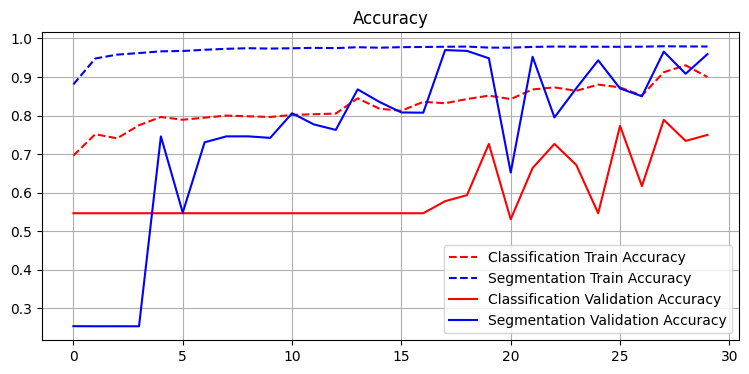

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


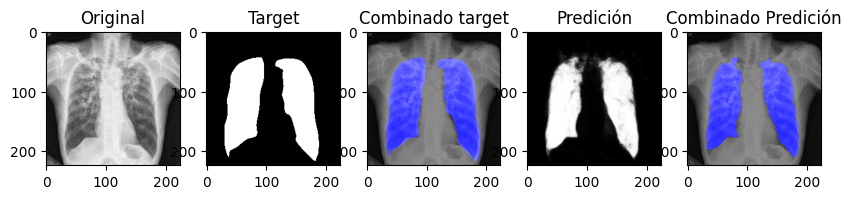

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


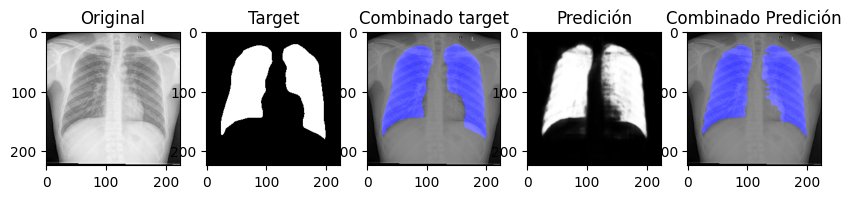

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


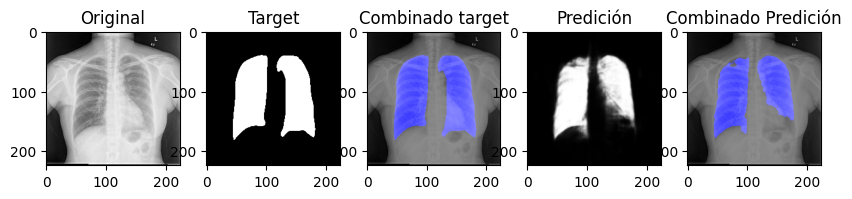

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


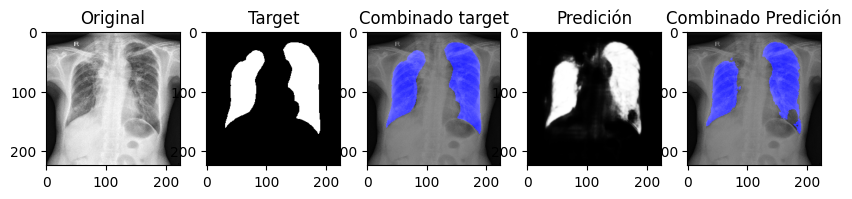

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


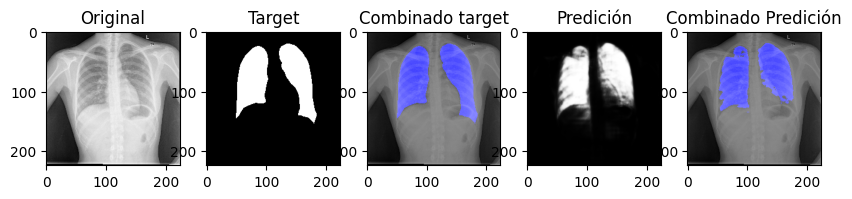

In [ ]:
showCompleteHistory()
view_val_examples(model, 5)


#Conclusiones

Se puede apreciar una leve mejora en el entrenamiento, principalmente del clasificador, aun así, se considera que hacen falta epocas para mejorar el rendimiento del sistema.
